# Importing Packages and loading data

In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


In [21]:

from xgboost import XGBRegressor, XGBClassifier, plot_importance, plot_tree
#Importing other useful packages
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import statistics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


In [22]:
# Load training data
train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [23]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [24]:
#Factorize categorical variable:
train['Sex_num'] = pd.factorize(train['Sex'])[0]

#Creating extra training data:
train['BMI'] = train['Weight']/train['Height']
train['BMI2'] = train['Weight'] / ((train['Height'] / 100) ** 2)
train['temp_to_hr_ratio'] = train['Body_Temp']/train['Heart_Rate']
train['Workout_Intensity'] = train['Heart_Rate'] * train['Duration']
train['Temp_duration'] = train['Body_Temp'] * train['Duration']


# Exploring data

In [25]:
train.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Sex_num,BMI,BMI2,temp_to_hr_ratio,Workout_Intensity,Temp_duration
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781,0.500961,0.426835,24.374817,0.422829,1541.562606,623.283247
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349,0.499999,0.050408,1.511310,0.036147,932.453480,343.646487
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000,0.000000,0.220859,12.375937,0.306504,67.000000,37.100000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000,0.000000,0.384181,23.255019,0.395146,728.000000,317.600000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000,1.000000,0.423913,24.391059,0.420879,1455.000000,606.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000,1.000000,0.469274,25.487697,0.447727,2323.000000,931.500000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000,1.000000,0.678082,46.443986,0.592537,3840.000000,1245.000000


In [26]:
train.select_dtypes(include=['int64','float64']).columns

Index(['id', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories', 'Sex_num', 'BMI', 'BMI2', 'temp_to_hr_ratio',
       'Workout_Intensity', 'Temp_duration'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<Axes: xlabel='Sex_num', ylabel='Count'>

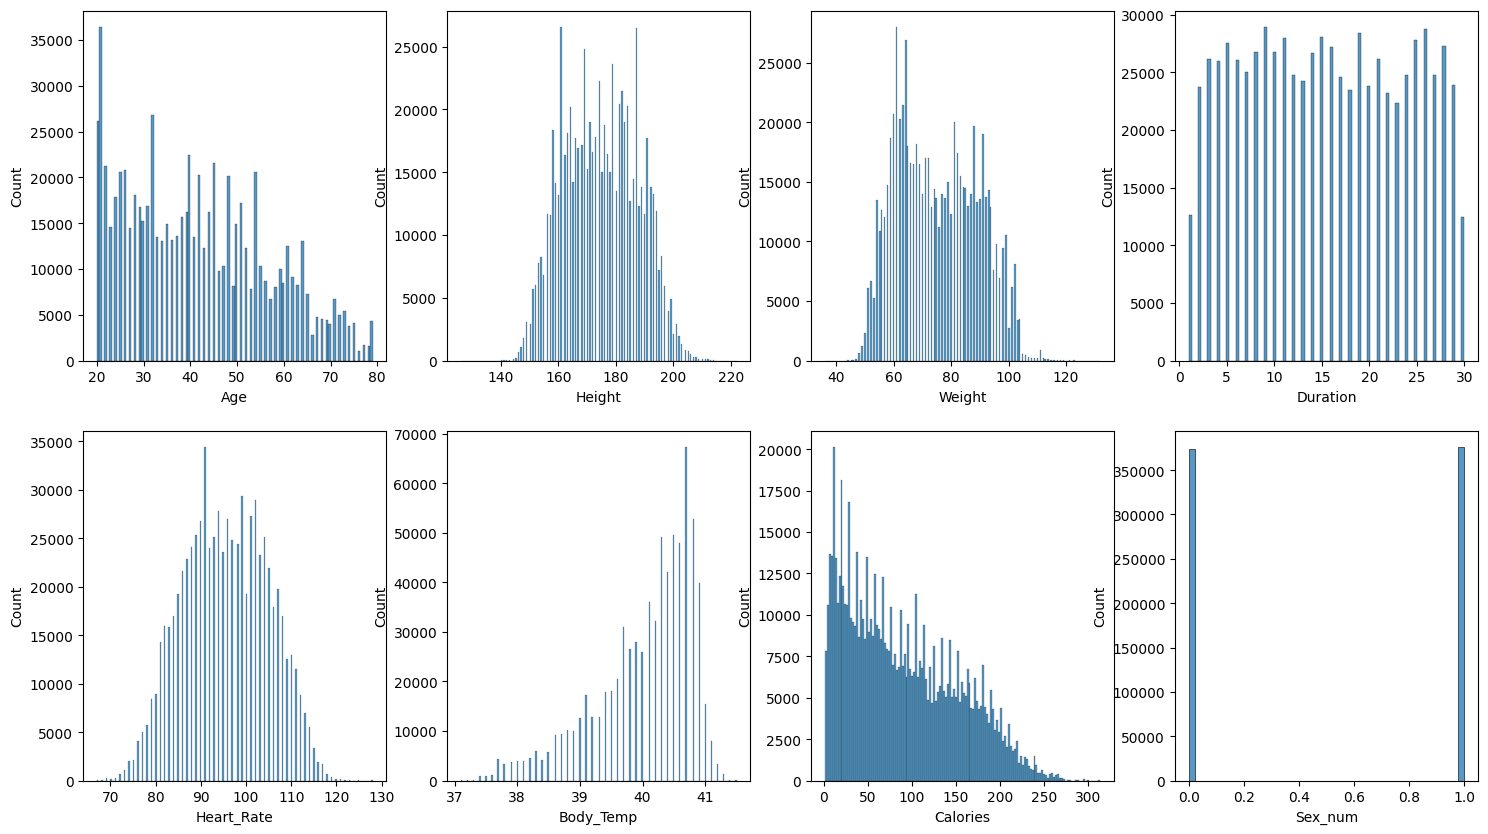

In [27]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))
sns.histplot(data=train, x='Age', ax=axes[0,0])
sns.histplot(data=train, x='Height', ax=axes[0,1])
sns.histplot(data=train, x='Weight', ax=axes[0,2])
sns.histplot(data=train, x='Duration', ax=axes[0,3])
sns.histplot(data=train, x='Heart_Rate', ax=axes[1,0])
sns.histplot(data=train, x='Body_Temp', ax=axes[1,1])
sns.histplot(data=train, x='Calories', ax=axes[1,2])
sns.histplot(data=train, x='Sex_num', ax=axes[1,3])


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<Axes: xlabel='Temp_duration', ylabel='Calories'>

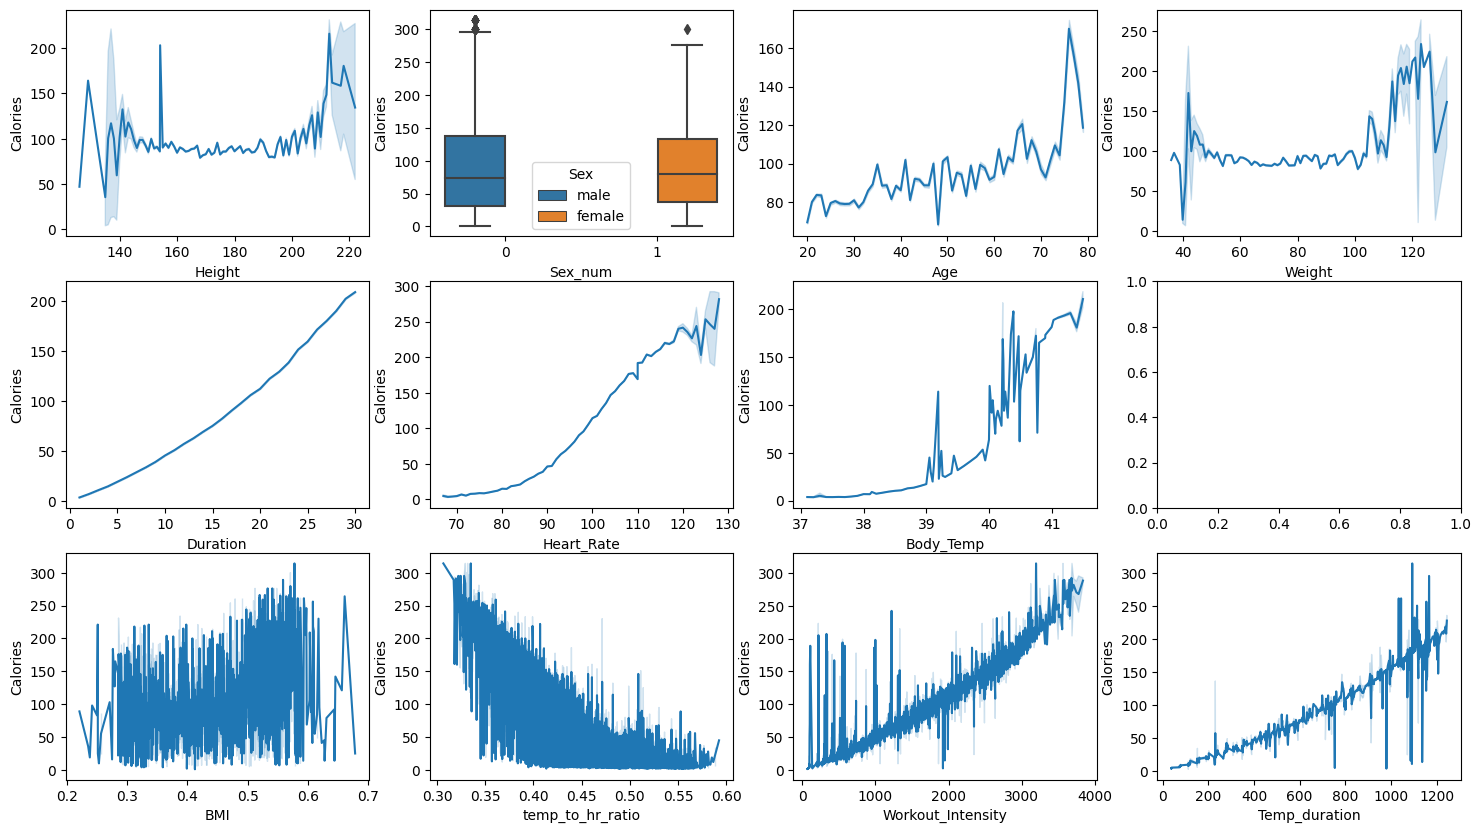

In [28]:

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 10))
sns.lineplot(x = train['Height'], y = train['Calories'], ax=axes[0,0])
sns.boxplot(x = train['Sex_num'], y =  train['Calories'], hue = train['Sex'], ax=axes[0,1])
sns.lineplot(x = train['Age'], y = train['Calories'], ax=axes[0,2])
sns.lineplot(x = train['Weight'], y = train['Calories'], ax=axes[0,3])
sns.lineplot(x = train['Duration'], y = train['Calories'],ax=axes[1,0])
sns.lineplot(x = train['Heart_Rate'], y = train['Calories'],ax=axes[1,1])
sns.lineplot(x = train['Body_Temp'], y = train['Calories'],ax=axes[1,2])
sns.lineplot(x = train['BMI'], y = train['Calories'],ax=axes[2,0])
sns.lineplot(x = train['temp_to_hr_ratio'], y = train['Calories'],ax=axes[2,1])
sns.lineplot(x = train['Workout_Intensity'], y = train['Calories'],ax=axes[2,2])     
sns.lineplot(x = train['Temp_duration'], y = train['Calories'],ax=axes[2,3]) 

In [29]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Sex_num,BMI,BMI2,temp_to_hr_ratio,Workout_Intensity,Temp_duration
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,0,0.433862,22.955684,0.405941,2626.0,1066.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,1,0.368098,22.582709,0.467059,680.0,317.6
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,1,0.397516,24.690405,0.473810,588.0,278.6
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,0,0.468750,24.414062,0.387619,2625.0,1017.5
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,1,0.367470,22.136740,0.398039,2550.0,1015.0


# Predictive Modeling

In [30]:
#Get list of all int/float values for modeling

train.select_dtypes(include=['int64','float64']).columns

Index(['id', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories', 'Sex_num', 'BMI', 'BMI2', 'temp_to_hr_ratio',
       'Workout_Intensity', 'Temp_duration'],
      dtype='object')

In [31]:
#Create X,y values
y = train['Calories']

features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp','Sex_num','Workout_Intensity',
       'BMI2','Temp_duration']

X = train[features]

In [32]:
#Selecting best features for modeling(Don't change any of this code)
feat_select = SelectKBest(f_classif, k='all')
feat_select.fit_transform(X, y)
feat_pvals = pd.DataFrame({'Feature' : X.columns, 'p_value' : feat_select.pvalues_}).sort_values('p_value') 
feat_pvals[feat_pvals['p_value'] < 0.05]

,Feature,p_value
0,Age,0.0
1,Height,0.0
2,Weight,0.0
3,Duration,0.0
4,Heart_Rate,0.0
5,Body_Temp,0.0
6,Sex_num,0.0
7,Workout_Intensity,0.0
8,BMI2,0.0
9,Temp_duration,0.0


In [33]:
#Split training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

**Key Hyperparameters**
* n_estimators: number of boosting rounds (trees)
* learning_rate: shrinks feature weights
* max_depth: limits tree depth to prevent overfitting
* eval_metric: metric used to evaluate model 

**Example:**
xgb_model = XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 3,eval_metric = 'mae')

In [34]:
#Add Parameters
model = XGBRegressor(n_estimators = 200, learning_rate = 0.1, max_depth = 10,eval_metric = 'mae')

#Fitting data to model
model.fit(train_X, train_y)

#Making predictions on data
val_predictions = model.predict(val_X)

#Getting MAE and Accuracy scores
val_mae = mean_absolute_error(val_predictions, val_y)

#Printing results
print("Validation MAE for Random Forest Model: {:,.0f}".format(val_mae))
print('The accuracy of the model is: ', model.score(val_X, val_y)) 
print('The accuracy of the training model is: ', model.score(train_X, train_y))

Validation MAE for Random Forest Model: 2
The accuracy of the model is:  0.9965312576725609
The accuracy of the training model is:  0.9978906271278215


In [35]:
output = pd.DataFrame({'Prediction': abs(val_predictions).round(),
                      'Calories Actual': val_y})
output.head()

,Prediction,Calories Actual
241943,95.0,84.0
108545,33.0,32.0
139329,133.0,134.0
67919,85.0,86.0
104755,100.0,97.0


In [36]:
#Create finalized model determined hyperparameters from above cell
final_model = XGBRegressor(n_estimators = 200, learning_rate = 0.1, max_depth = 10,eval_metric = 'mae')
#Fit model to full training data
final_model.fit(X,y)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)